In [1]:
try:
    import imblearn
except ImportError:
    print("imbalanced-learn not found. Installing...")
    !pip install imbalanced-learn
    print("imbalanced-learn installed successfully!")

# Now import and use imbalanced-learn
from imblearn.over_sampling import RandomOverSampler

In [2]:
# Importing necessary packages
import os
import numpy as np
import pandas as pd
import logging
import warnings
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import csv

from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score



from sklearn.metrics import classification_report, roc_curve, accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler
import xgboost as xgb
import matplotlib.pyplot as plt


warnings.filterwarnings('ignore')

# Setting up logging with a FileHandler
log_file_path = 'logger_log.txt'
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

file_handler = logging.FileHandler(log_file_path)
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))

logger = logging.getLogger(__name__)
logger.addHandler(file_handler)

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


In [4]:
# Reading the dataset
dataset_path = "/kaggle/input/us-stock-market-2020-to-2024/US Stock Market Dataset.csv"

try:
    # Attempt to read the dataset
    df = pd.read_csv(dataset_path)
    logger.info(f"Dataset loaded successfully from {dataset_path}")
except FileNotFoundError:
    logger.error("Error: Dataset file not found. Please provide the correct file path.")
except Exception as e:
    logger.error(f"An error occurred: {e}")
    
# Rename the first column
df = df.rename(columns={df.columns[0]: 'date_index'})
print(df.columns)

df = df[['date_index','Natural_Gas_Price','Natural_Gas_Vol.']]
df['prev_index'] = df['date_index'] + 1
df.head(5)

Index(['date_index', 'Date', 'Natural_Gas_Price', 'Natural_Gas_Vol.',
       'Crude_oil_Price', 'Crude_oil_Vol.', 'Copper_Price', 'Copper_Vol.',
       'Bitcoin_Price', 'Bitcoin_Vol.', 'Platinum_Price', 'Platinum_Vol.',
       'Ethereum_Price', 'Ethereum_Vol.', 'S&P_500_Price', 'Nasdaq_100_Price',
       'Nasdaq_100_Vol.', 'Apple_Price', 'Apple_Vol.', 'Tesla_Price',
       'Tesla_Vol.', 'Microsoft_Price', 'Microsoft_Vol.', 'Silver_Price',
       'Silver_Vol.', 'Google_Price', 'Google_Vol.', 'Nvidia_Price',
       'Nvidia_Vol.', 'Berkshire_Price', 'Berkshire_Vol.', 'Netflix_Price',
       'Netflix_Vol.', 'Amazon_Price', 'Amazon_Vol.', 'Meta_Price',
       'Meta_Vol.', 'Gold_Price', 'Gold_Vol.'],
      dtype='object')


,date_index,Natural_Gas_Price,Natural_Gas_Vol.,prev_index
0,0,2.079,NaN,1
1,1,2.050,161340.0,2
2,2,2.100,142860.0,3
3,3,2.077,139750.0,4
4,4,2.490,3590.0,5


In [5]:
def get_prev_pane(df,y,index_col):
    df['prev_index'] = df[index_col] + y
    column_names = df.columns
    df_tmp = pd.merge(df, df, left_on=index_col, right_on='prev_index', how='inner', suffixes=("_"+str(y),''))
    df_tmp = df_tmp.drop(column_names,axis=1)
    df_tmp = df_tmp.drop(['prev_index'+"_"+str(y),index_col+"_"+str(y)],axis=1)
    return df_tmp

In [6]:
for i in range (0,20,1):
    prev_df = get_prev_pane(df,i,'date_index')
    if i == 0:
        final_df = prev_df
    else:
        final_df = pd.merge(final_df, prev_df, left_index=True, right_index=True)
    
final_df.head(10)

,Natural_Gas_Price_0,Natural_Gas_Vol._0,Natural_Gas_Price_1,Natural_Gas_Vol._1,Natural_Gas_Price_2,Natural_Gas_Vol._2,Natural_Gas_Price_3,Natural_Gas_Vol._3,Natural_Gas_Price_4,Natural_Gas_Vol._4,...,Natural_Gas_Price_15,Natural_Gas_Vol._15,Natural_Gas_Price_16,Natural_Gas_Vol._16,Natural_Gas_Price_17,Natural_Gas_Vol._17,Natural_Gas_Price_18,Natural_Gas_Vol._18,Natural_Gas_Price_19,Natural_Gas_Vol._19
0,2.079,NaN,2.050,161340.0,2.100,142860.0,2.077,139750.0,2.490,3590.0,...,3.097,235030.0,3.039,258010.0,3.190,351780.0,2.980,237670.0,2.893,187500.0
1,2.050,161340.0,2.100,142860.0,2.077,139750.0,2.490,3590.0,2.712,73020.0,...,3.039,258010.0,3.190,351780.0,2.980,237670.0,2.893,187500.0,2.821,206310.0
2,2.100,142860.0,2.077,139750.0,2.490,3590.0,2.712,73020.0,2.571,44980.0,...,3.190,351780.0,2.980,237670.0,2.893,187500.0,2.821,206310.0,2.668,166470.0
3,2.077,139750.0,2.490,3590.0,2.712,73020.0,2.571,44980.0,2.641,65500.0,...,2.980,237670.0,2.893,187500.0,2.821,206310.0,2.668,166470.0,2.568,132450.0
4,2.490,3590.0,2.712,73020.0,2.571,44980.0,2.641,65500.0,2.450,69160.0,...,2.893,187500.0,2.821,206310.0,2.668,166470.0,2.568,132450.0,2.514,89600.0
5,2.712,73020.0,2.571,44980.0,2.641,65500.0,2.450,69160.0,2.419,121580.0,...,2.821,206310.0,2.668,166470.0,2.568,132450.0,2.514,89600.0,2.557,116060.0
6,2.571,44980.0,2.641,65500.0,2.450,69160.0,2.419,121580.0,2.519,138430.0,...,2.668,166470.0,2.568,132450.0,2.514,89600.0,2.557,116060.0,2.619,3930.0
7,2.641,65500.0,2.450,69160.0,2.419,121580.0,2.519,138430.0,2.697,151820.0,...,2.568,132450.0,2.514,89600.0,2.557,116060.0,2.619,3930.0,2.550,50760.0
8,2.450,69160.0,2.419,121580.0,2.519,138430.0,2.697,151820.0,2.870,150330.0,...,2.514,89600.0,2.557,116060.0,2.619,3930.0,2.550,50760.0,2.610,42840.0
9,2.419,121580.0,2.519,138430.0,2.697,151820.0,2.870,150330.0,2.900,228160.0,...,2.557,116060.0,2.619,3930.0,2.550,50760.0,2.610,42840.0,2.572,84550.0


In [7]:
col_names = final_df.columns[1:].tolist()

# creating a copy of df
df1 = final_df.fillna(0)

#target column name
label_name = 'Natural_Gas_Price_0'


# defining the features and target
X = df1.drop([label_name],axis=1)
y = df1[[label_name]]

# instantiating the scaler
scaler = RobustScaler()

# scaling the continuous featuree
X[col_names] = scaler.fit_transform(X[col_names])

# Get centering and scaling values for each feature
centering = scaler.center_
iqrs  = scaler.scale_

X.head()

,Natural_Gas_Vol._0,Natural_Gas_Price_1,Natural_Gas_Vol._1,Natural_Gas_Price_2,Natural_Gas_Vol._2,Natural_Gas_Price_3,Natural_Gas_Vol._3,Natural_Gas_Price_4,Natural_Gas_Vol._4,Natural_Gas_Price_5,...,Natural_Gas_Price_15,Natural_Gas_Vol._15,Natural_Gas_Price_16,Natural_Gas_Vol._16,Natural_Gas_Price_17,Natural_Gas_Vol._17,Natural_Gas_Price_18,Natural_Gas_Vol._18,Natural_Gas_Price_19,Natural_Gas_Vol._19
0,-1.649602,-0.357806,0.483326,-0.336709,0.238719,-0.346414,0.197437,-0.172152,-1.587624,-0.078448,...,0.084595,1.432159,0.061901,1.736892,0.126040,2.971404,0.039875,1.477250,0.004566,0.818555
1,0.483326,-0.336709,0.239019,-0.346414,0.197747,-0.172152,-1.587624,-0.078481,-0.677395,-0.137916,...,0.060366,1.731963,0.124844,2.963726,0.038686,1.474585,0.003738,0.817964,-0.025322,1.065917
2,0.239019,-0.346414,0.197905,-0.172152,-1.596074,-0.078481,-0.677395,-0.137975,-1.045000,-0.108393,...,0.123446,2.955316,0.037307,1.470775,0.002496,0.816488,-0.026168,1.065147,-0.088834,0.542000
3,0.197905,-0.172152,-1.602142,-0.078481,-0.681378,-0.137975,-1.045000,-0.108439,-0.775982,-0.188950,...,0.035718,1.466601,0.001042,0.814379,-0.027454,1.063226,-0.089720,0.541608,-0.130345,0.094618
4,-1.602142,-0.078481,-0.684271,-0.137975,-1.050787,-0.108439,-0.775982,-0.189030,-0.728000,-0.202024,...,-0.000627,0.812068,-0.028970,1.060478,-0.091098,0.540631,-0.131256,0.094550,-0.152760,-0.468883


In [8]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [9]:
# Defining a dictionary of regression models
regressors = {
    'AdaBoostRegressor': AdaBoostRegressor(),
    'LinearRegression': LinearRegression(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=0),
    'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators=300, max_depth=1, subsample=0.8, max_features=0.2),
    'XGBRegressor': XGBRegressor(objective='reg:squarederror'),
}

AdaBoostRegressor CV Scores: [-0.10943118 -0.06341    -0.04817554 -0.08104153 -0.06096983]
AdaBoostRegressor Mean Squared Error (MSE): 0.07232416508421811
AdaBoostRegressor Root Mean Squared Error (RMSE): 0.2689315248984732
AdaBoostRegressor Mean Absolute Error (MAE): 0.1957608709069571
AdaBoostRegressor R^2 Score: 0.9824965716550446


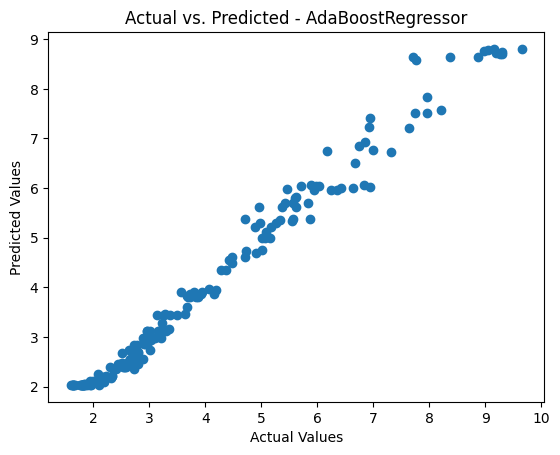

LinearRegression CV Scores: [-0.08348828 -0.04385723 -0.03451218 -0.05219649 -0.03974354]
LinearRegression Mean Squared Error (MSE): 0.04282340342462503
LinearRegression Root Mean Squared Error (RMSE): 0.20693816328706754
LinearRegression Mean Absolute Error (MAE): 0.1472033051457275
LinearRegression R^2 Score: 0.989636155876017


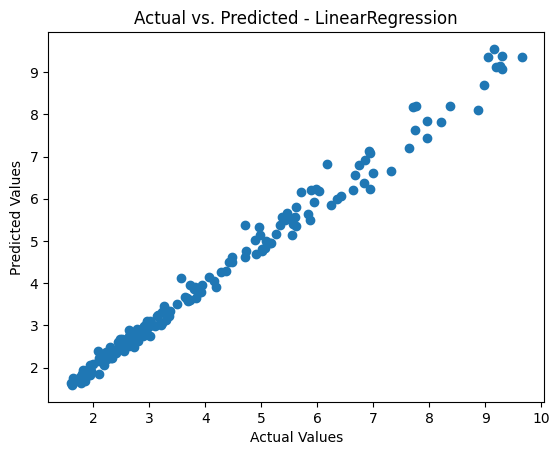

KNeighborsRegressor CV Scores: [-0.30465355 -0.25921443 -0.18401607 -0.19403391 -0.17996406]
KNeighborsRegressor Mean Squared Error (MSE): 0.17569766673366835
KNeighborsRegressor Root Mean Squared Error (RMSE): 0.4191630550676769
KNeighborsRegressor Mean Absolute Error (MAE): 0.3227396984924623
KNeighborsRegressor R^2 Score: 0.9574787829701515


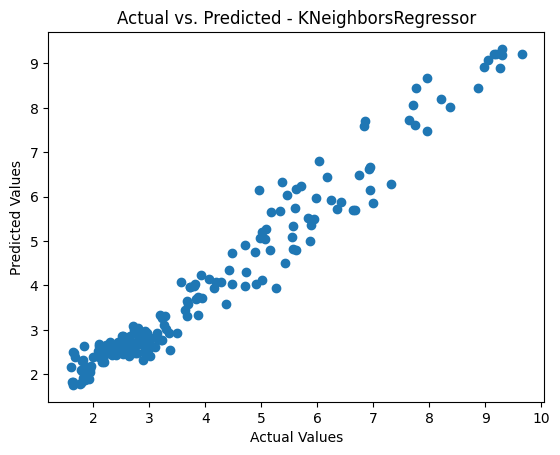

RandomForestRegressor CV Scores: [-0.0958347  -0.04297096 -0.03976188 -0.05278424 -0.04955446]
RandomForestRegressor Mean Squared Error (MSE): 0.045072113815075414
RandomForestRegressor Root Mean Squared Error (RMSE): 0.21230194020563123
RandomForestRegressor Mean Absolute Error (MAE): 0.14608261306532663
RandomForestRegressor R^2 Score: 0.989091937478999


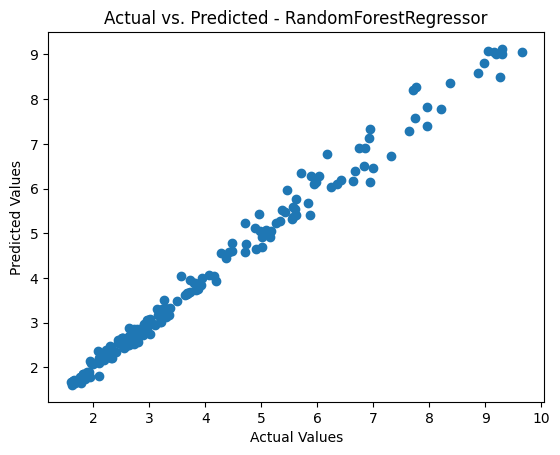

GradientBoostingRegressor CV Scores: [-0.17327225 -0.11412703 -0.09134121 -0.10590573 -0.09613643]
GradientBoostingRegressor Mean Squared Error (MSE): 0.08789390072095128
GradientBoostingRegressor Root Mean Squared Error (RMSE): 0.29646905525020867
GradientBoostingRegressor Mean Absolute Error (MAE): 0.21369086919953698
GradientBoostingRegressor R^2 Score: 0.9787284845744662


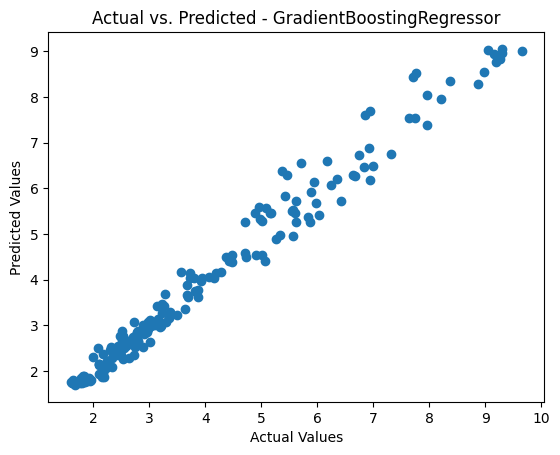

XGBRegressor CV Scores: [-0.10618961 -0.05115621 -0.05182512 -0.0660625  -0.06555323]
XGBRegressor Mean Squared Error (MSE): 0.042000816733441186
XGBRegressor Root Mean Squared Error (RMSE): 0.20494100793506698
XGBRegressor Mean Absolute Error (MAE): 0.14264299605479794
XGBRegressor R^2 Score: 0.989835233005907


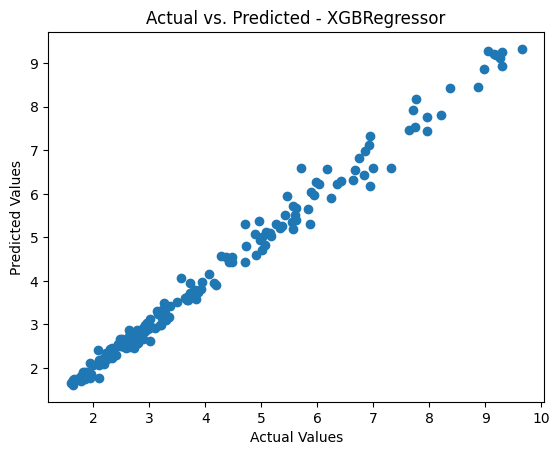

In [10]:
# Improved model evaluation and cross-validation for regression
model_results = []

# Looping through regression models and evaluating their performance
for name, model in regressors.items():
    try:
        logger.info(f"Training and evaluating {name} model.")
        
        # Cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

        # Model training
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        # Evaluation metrics for regression
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)

        model_results.append({'Model': name, 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R^2': r2, 'CV Scores': cv_scores})
        
        print("=============================================================================")
        print(name, "CV Scores:", cv_scores)
        print(name, "Mean Squared Error (MSE):", mse)
        print(name, "Root Mean Squared Error (RMSE):", rmse)
        print(name, "Mean Absolute Error (MAE):", mae)
        print(name, "R^2 Score:", r2)
        
        logger.info(f"{name} - CV Scores: {cv_scores}")
        logger.info(f"{name} - MSE: {mse}")
        logger.info(f"{name} - RMSE: {rmse}")
        logger.info(f"{name} - MAE: {mae}")
        logger.info(f"{name} - R^2 Score: {r2}")

        # Plotting the actual vs. predicted values
        plt.scatter(y_test, predictions)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Actual vs. Predicted - {name}')
        plt.show()

    except Exception as ex:
        print(ex)
        logger.error(f"An error occurred while processing {name} model: {ex}")


In [11]:
df_results = pd.DataFrame(model_results)
df_results

,Model,MSE,RMSE,MAE,R^2,CV Scores
0,AdaBoostRegressor,0.072324,0.268932,0.195761,0.982497,"[-0.10943118235609038, -0.06340999848434178, -..."
1,LinearRegression,0.042823,0.206938,0.147203,0.989636,"[-0.08348828260926865, -0.04385723162249994, -..."
2,KNeighborsRegressor,0.175698,0.419163,0.322740,0.957479,"[-0.3046535547169811, -0.2592144304402515, -0...."
3,RandomForestRegressor,0.045072,0.212302,0.146083,0.989092,"[-0.09583470150817602, -0.042970959966666764, ..."
4,GradientBoostingRegressor,0.087894,0.296469,0.213691,0.978728,"[-0.17327224615580314, -0.11412702825817407, -..."
5,XGBRegressor,0.042001,0.204941,0.142643,0.989835,"[-0.10618960946522095, -0.05115621326715223, -..."


In [12]:
# Save log messages to a file
# File handling: close the FileHandler
file_handler.close()
logger.removeHandler(file_handler)